## Preprocessing settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.getcwd())

/content


In [13]:
ratio = 80
in_path = '/content/drive/MyDrive/Colab Notebooks/rnnrec/data/ml-1m-raw/'
ratings_file = in_path + 'ratings.dat'

## Load data file

In [14]:
# Load the input file in memory
raw = []
with open(ratings_file, 'r') as f_read:
    for line in f_read.readlines():
        line_list = line.split('::')
        raw.append(line_list)

## Data's skewness

users` max freq: 2314
items` max freq: 3428


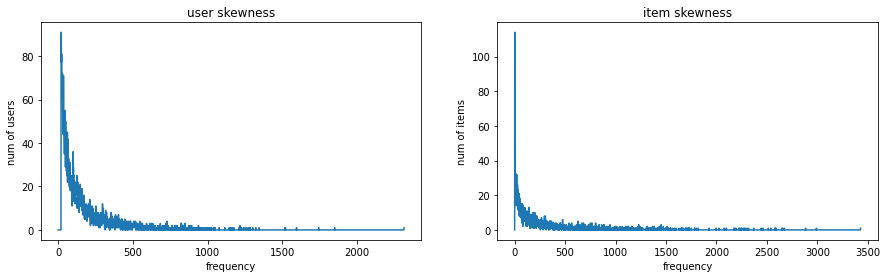

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,4)

raw = np.array(raw, dtype=int)
user_freq = np.bincount(raw[:, 0]) # [user1's freq, user2's freq, ..., usern's freq]
user_freq = [i for i in user_freq if i>0] # exclude dummy users
user_freq = np.bincount(user_freq)
user_x_axis = np.array(range(len(user_freq)))
print(f'users` max freq: {len(user_freq)-1}')

item_freq = np.bincount(raw[:, 1]) #[item1's freq, item2's freq, ..., itemm's freq]
item_freq = [i for i in item_freq if i>0] # exclude dummy items
item_freq = np.bincount(item_freq)
item_x_axis = np.array(range(len(item_freq)))
print(f'items` max freq: {len(item_freq)-1}')

fig, axs = plt.subplots(1, 2)
axs[0].plot(user_x_axis, user_freq)
axs[0].set_title('user skewness')
axs[0].set_xlabel('frequency')
axs[0].set_ylabel('num of users')
axs[1].plot(item_x_axis, item_freq)
axs[1].set_title('item skewness')
axs[1].set_xlabel('frequency')
axs[1].set_ylabel('num of items')
plt.show()

## Sort interactions by (u_id, time)

In [16]:
raw_sorted = np.array(sorted(raw, key=lambda x: (x[0], x[3])))
print(f'num of interactions: {len(raw_sorted)}')

num of interactions: 1000209


## Assign new ids

In [17]:
user_ids = list()
item_ids = list()
user_map = dict() # raw -> new
item_map = dict() # raw -> new

user_ids = np.unique(raw[:, 0])
item_ids = np.unique(raw[:, 1])

user_map = {v: i for (i, v) in enumerate(user_ids)}
item_map = {v: i for (i, v) in enumerate(item_ids)}
new_sorted = [[user_map[u], item_map[i]] for (u, i)
              in zip(raw_sorted[:, 0], raw_sorted[:, 1])] # new array


## Construct train/test lists

In [18]:
trn_list = list()
test_list = list()

index = new_sorted[0][0]
buf = [] # Sequence for each user
for i in range(len(new_sorted)):
    if index == new_sorted[i][0]:
        buf.append(new_sorted[i])
        continue
    split_i = round(len(buf) * float(ratio/100))
    trn = buf[:split_i]
    test = buf[split_i:]
    for line in trn:
        trn_list.append([line[0], line[1]])
    for line in test:
        test_list.append([line[0], line[1]])
    index = new_sorted[i][0]
    buf = [new_sorted[i]]
split_i = int(len(buf) * float(ratio / 100))
trn = buf[:split_i]
test = buf[split_i:]
for line in trn:
    trn_list.append([line[0], line[1]])
for line in test:
    test_list.append([line[0], line[1]])

## Construct dictionary of side information

In [19]:
movies_file = in_path + 'movies.dat'
meta_dict = dict()
        
with open(movies_file, 'r',  encoding='ISO-8859-1') as f_read:
    for line in f_read.readlines():
        line_list = line.split('::')
        raw_id = int(line_list[0].strip())
        try:
            new_id = item_map[raw_id]
        except KeyError:
            continue
        meta_dict[new_id] = [line_list[1].strip(), line_list[2].strip()]

## Data instance parameters

In [20]:
feed_len = 5
target_len = 3
neg_samples = 20

## Make data instances

In [21]:
def generate_training_instances(user_ids, items, indices, max_len):
    for i in range(len(indices)):
        # set start_idx and stop_idx for each user
        start_idx = indices[i]
        if i >= len(indices) - 1:
            stop_idx =None
        else:
            stop_idx = indices[i + 1]
            
        for seq in sliding_window(items[start_idx:stop_idx], max_len):
            yield (user_ids[i], seq)

def sliding_window(tensor, window_size):
    for i in range(len(tensor)):
        if i + window_size > len(tensor):
            break
        else:
            yield tensor[i:i+window_size]

In [22]:
"""
If a user interacted with items [1, 2, 3, 4, 5, 6, 7, 8, 9],
the returned interactions matrix at sequence lenght 5 and target length 2 will be:

trn_feed_sequences:
[[1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6],
 [3, 4, 5, 6, 7]]

trn_target_sequences:
 [[6, 7],
  [7, 8],
  [8, 9]]

test_feed_sequences:
  [[5, 6, 7, 8, 9]]
"""

trn_list = np.array(trn_list)
test_list = np.array(test_list)

# user_ids: unique user ids
# indices: first index of each user
# counts: number of each user's interactions
user_ids, indices, counts = np.unique(trn_list[:, 0],
                                      return_index=True, return_counts=True)

items = trn_list[:, 1]

max_len = feed_len + target_len
num_sequences = sum([c - max_len + 1 if c >= max_len else 1 for c in counts])
num_users = len(user_ids)

trn_feed_sequences = np.zeros(shape=(num_sequences, feed_len), dtype=np.int32)
trn_positive_targets = np.zeros(shape=(num_sequences, target_len), dtype=np.int32)
trn_users = np.empty(num_sequences, dtype=np.int32)
test_feed_sequences = np.zeros(shape=(num_users, feed_len), dtype=np.int32)
test_users = np.empty(num_users, dtype=np.int32)

for i, (uid, item_seq) in enumerate(
    generate_training_instances(user_ids, items, indices, max_len)):
    trn_feed_sequences[i][:] = item_seq[:feed_len]
    trn_positive_targets[i][:] = item_seq[-target_len:]
    trn_users[i] = uid
    test_feed_sequences[uid][:] = item_seq[-feed_len:]
    test_users[uid] = uid

In [ ]:
def generate_test_instances(user_ids, items, indices):
        for i in range(len(indices)):
            # set start_idx and stop_idx for each user
            start_idx = indices[i]
            if i >= len(indices) - 1:
                stop_idx =None
            else:
                stop_idx = indices[i + 1]

            yield(user_ids[i], items[start_idx:stop_idx])

In [ ]:
user_ids, indices, counts = np.unique(test_list[:, 0], return_index=True, return_counts=True)

items = test_list[:, 1]
test_targets = []

for uid, item_seq in generate_test_instances(user_ids, items, indices):
    test_targets.append(item_seq)

In [ ]:
num_users = len(user_map)
num_items = len(item_map)
trn_negative_targets = np.random.randint(num_items,
                                         size=(num_sequences, target_len * neg_samples))

## Model parameters

In [ ]:
lr = 1e-3
batch_size = 1000
epochs = 15
emb_dim = 50
hid_dim = 50
epsilon = 1e-10 # This prevents the occurrence of log(0)

## Shuffle

In [ ]:
def shuffle(*arrays):
    shuffle_indices = np.arange(len(arrays[0]))
    np.random.shuffle(shuffle_indices)
    return tuple(x[shuffle_indices] for x in arrays)

In [ ]:
_trn_users, _trn_feed_sequences, _trn_positive_targets, _trn_negative_targets = \
shuffle(trn_users, trn_feed_sequences, trn_positive_targets, trn_negative_targets)

## Batch loader

In [ ]:
def minibatch(*tensors, batch_size=1000):
    for i in range(0, len(tensors[0]), batch_size):
        yield tuple(x[i:i+batch_size] for x in tensors)

## Evaluation metrics

In [ ]:
def compute_precision(predictions, targets, k):
    pred = predictions[:k]
    num_hit = len(set(pred).intersection(set(targets)))
    return float(num_hit) / len(pred)

def compute_recall(predictions, targets, k):
    pred = predictions[:k]
    num_hit = len(set(pred).intersection(set(targets)))
    return float(num_hit) / len(targets)

def compute_ap(predictions, targets, k):
    if len(predictions) > k:
        predictions = predictions[:k]
    score = 0.
    num_hits = 0.
    for i, p in enumerate(predictions):
        if p in targets:
            num_hits += 1.
            score += num_hits / (i+1)
    return score / min(len(targets), k)

def evaluate(preds, gts, k=10, map_k=50):
    precs = [compute_precision(p, t, k=k) for (p, t) in zip(preds, gts)]
    recalls = [compute_recall(p, t, k=k) for (p, t) in zip(preds, gts)]
    aps = [compute_ap(p, t, k=map_k) for (p, t) in zip(preds, gts)]
    return float(sum(precs) / len(precs)), \
            float(sum(recalls) / len(recalls)), \
            float(sum(aps) / len(aps))

## Prepare Multi-input model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, multiply, Dense, Embedding, LSTM, concatenate, dot
tf.keras.backend.clear_session()

class my_model(tf.keras.Model):
    def __init__(self, num_items, num_users, emb_dim, hid_dim, feed_len, target_len, epsilon):
        super(my_model, self).__init__(self)
        self.epsilon = epsilon
        self.item = 
        self.user = 
        self.target = 
        self.lstm = 
        self.lstm_dense = 
        self.final = 
   
    def call(self, item, user):
        item_out = 
        user_embedding = 
        concat = 
        model_out = 
        return model_out
   
    def loss(self, model_out, Y_positive, Y_negative):
        concat = 
        positive_logits = 
        negative_logits =
        positive_loss = 
        negative_loss =

        return tf.reduce_sum(positive_loss + negative_loss)
    
    def predict(self, model_out, test_instance):
        all_logits = 
        _predict = 
        _predict = 
        return _predict

model = my_model(num_items, num_users, emb_dim, hid_dim, feed_len, target_len, epsilon)

opt = tf.keras.optimizers.Adam()


## Train & Test the model

In [ ]:
import time

k = 10
map_k = 50

for epoch in range(epochs):
    start_time = time.time()
    '''
    Train the model
    '''

    '''
    Test the model
    '''



Epoch: 1	Loss: 11235.0869 [42.3 s]	Prec@10: 0.0433	Recall@10: 0.0241	MAP: 0.0171 [2.6 s]
Epoch: 2	Loss: 9563.0879 [36.4 s]	Prec@10: 0.0403	Recall@10: 0.0238	MAP: 0.0173 [2.6 s]
Epoch: 3	Loss: 8213.0254 [37.1 s]	Prec@10: 0.0744	Recall@10: 0.0442	MAP: 0.0344 [2.6 s]
Epoch: 4	Loss: 7012.3276 [36.2 s]	Prec@10: 0.1000	Recall@10: 0.0593	MAP: 0.0495 [2.6 s]
Epoch: 5	Loss: 6443.8652 [36.2 s]	Prec@10: 0.1093	Recall@10: 0.0651	MAP: 0.0563 [2.5 s]
Epoch: 6	Loss: 6112.7515 [36.7 s]	Prec@10: 0.1175	Recall@10: 0.0727	MAP: 0.0629 [2.5 s]
Epoch: 7	Loss: 5856.6104 [35.8 s]	Prec@10: 0.1212	Recall@10: 0.0759	MAP: 0.0662 [2.5 s]
Epoch: 8	Loss: 5661.7314 [35.2 s]	Prec@10: 0.1233	Recall@10: 0.0777	MAP: 0.0683 [2.5 s]
Epoch: 9	Loss: 5507.9131 [35.6 s]	Prec@10: 0.1230	Recall@10: 0.0781	MAP: 0.0685 [2.5 s]
Epoch: 10	Loss: 5383.4902 [35.3 s]	Prec@10: 0.1213	Recall@10: 0.0772	MAP: 0.0684 [2.5 s]
Epoch: 11	Loss: 5275.7983 [35.1 s]	Prec@10: 0.1208	Recall@10: 0.0767	MAP: 0.0680 [2.5 s]
Epoch: 12	Loss: 5179.6035 [35

## Qualitative evaluation

In [ ]:
from random import randint
idx = randint(0, len(test_users))

def mask2str(mask):
    return 'O' if mask else 'X'

==== Watched history ====
['Saving Private Ryan (1998)', 'Action|Drama|War']
['Forrest Gump (1994)', 'Comedy|Romance|War']
['Clerks (1994)', 'Comedy']
['Edward Scissorhands (1990)', 'Drama|Romance']
['Insider, The (1999)', 'Drama']
==== Real targets ===
['O'] ['American Beauty (1999)', 'Comedy|Drama']
['O'] ['Fight Club (1999)', 'Drama']
['O'] ['Being John Malkovich (1999)', 'Comedy']
['O'] ['Sixth Sense, The (1999)', 'Thriller']
['O'] ['Green Mile, The (1999)', 'Drama|Thriller']
=== Predicted targets ===
['O'] ['Fight Club (1999)', 'Drama']
['X'] ['Clerks (1994)', 'Comedy']
['O'] ['Sixth Sense, The (1999)', 'Thriller']
['X'] ['Election (1999)', 'Comedy']
['O'] ['Being John Malkovich (1999)', 'Comedy']
['O'] ['Green Mile, The (1999)', 'Drama|Thriller']
['X'] ['Go (1999)', 'Crime']
['X'] ['Dogma (1999)', 'Comedy']
['X'] ['Eyes Wide Shut (1999)', 'Drama']
['X'] ['Jerry Maguire (1996)', 'Drama|Romance']
['X'] ['Professional, The (a.k.a. Leon: The Professional) (1994)', 'Crime|Drama|Romanc